In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from collections import defaultdict
from scipy.stats.stats import pearsonr

In [2]:
df = pd.read_csv('training.csv') 

In [3]:
df.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,326,1,10/25/2010,ADESA,2008,2,KIA,SPECTRA,EX,4D SEDAN EX,...,9605.0,10650.0,NaN,NaN,5546,33619,FL,6100.0,0,533
1,42991,0,5/27/2009,MANHEIM,2006,3,DODGE,STRATUS V6 2.7L V6 M,SXT,4D SEDAN SXT FFV,...,6418.0,7478.0,NaN,NaN,99750,32124,FL,4000.0,0,1630
2,55273,0,3/18/2010,OTHER,2008,2,DODGE,CALIBER,SE,4D WAGON,...,10721.0,11350.0,NaN,NaN,99761,74135,OK,7500.0,0,693
3,29058,0,6/8/2009,OTHER,2005,4,FORD,FREESTAR FWD V6 3.9L,S,PASSENGER 3.9L,...,5702.0,7691.0,NaN,NaN,99761,85018,AZ,4725.0,0,1633
4,34991,0,3/4/2009,MANHEIM,2005,4,CHRYSLER,TOWN & COUNTRY FWD V,Bas,MINIVAN 3.3L,...,6300.0,7856.0,NaN,NaN,20833,75236,TX,5670.0,0,1623


In [12]:
df['MMRAcquisitionAuctionAveragePrice'].fillna(df['MMRAcquisitionAuctionAveragePrice'].median(), inplace = True)
df['MMRAcquisitionAuctionCleanPrice'].fillna(df['MMRAcquisitionAuctionCleanPrice'].median(), inplace = True)
df['MMRAcquisitionRetailAveragePrice'].fillna(df['MMRAcquisitionRetailAveragePrice'].median(), inplace = True)
df['MMRAcquisitonRetailCleanPrice'].fillna(df['MMRAcquisitonRetailCleanPrice'].median(), inplace = True)
df['MMRCurrentAuctionAveragePrice'].fillna(df['MMRCurrentAuctionAveragePrice'].median(), inplace = True)
df['MMRCurrentAuctionCleanPrice'].fillna(df['MMRCurrentAuctionCleanPrice'].median(), inplace = True)
df['MMRCurrentRetailAveragePrice'].fillna(df['MMRCurrentRetailAveragePrice'].median(), inplace = True)
df['MMRCurrentRetailCleanPrice'].fillna(df['MMRCurrentRetailCleanPrice'].median(), inplace = True)

In [17]:
df['MMR_factor'] = ( df['MMRAcquisitionAuctionAveragePrice'] + df['MMRAcquisitonRetailCleanPrice'] + df['MMRCurrentAuctionCleanPrice'] + df['MMRCurrentRetailAveragePrice']) / 4

In [51]:
df_new = df[['MMR_factor','VehBCost','WarrantyCost']]

In [52]:
df_new.head()

,MMR_factor,VehBCost,WarrantyCost
0,8685.25,6100.0,533
1,6459.25,4000.0,1630
2,9635.50,7500.0,693
3,6217.00,4725.0,1633
4,6551.25,5670.0,1623


In [53]:
df.isnull().sum()

RefId                                    0
IsBadBuy                                 0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  1911
SubModel                                 7
Color                                    7
Transmission                             8
WheelTypeID                           2573
WheelType                             2577
VehOdo                                   0
Nationality                              4
Size                                     4
TopThreeAmericanName                     4
MMRAcquisitionAuctionAveragePrice        0
MMRAcquisitionAuctionCleanPrice          0
MMRAcquisitionRetailAveragePrice         0
MMRAcquisitonRetailCleanPrice            0
MMRCurrentAuctionAveragePrice            0
MMRCurrentA

In [54]:
df_new.isnull().sum()

MMR_factor      0
VehBCost        0
WarrantyCost    0
dtype: int64

In [55]:
scaler = StandardScaler() 
scaler.fit(df_new.head().values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [56]:
df_new.head().values

array([[8685.25, 6100.  ,  533.  ],
       [6459.25, 4000.  , 1630.  ],
       [9635.5 , 7500.  ,  693.  ],
       [6217.  , 4725.  , 1633.  ],
       [6551.25, 5670.  , 1623.  ]])

In [57]:
scaler.transform(df_new.head().values)

array([[ 0.84867757,  0.41777513, -1.37838809],
       [-0.75829442, -1.3333781 ,  0.81495646],
       [ 1.53467269,  1.58521061, -1.05848369],
       [-0.93317715, -0.72881329,  0.82095467],
       [-0.69187868,  0.05920566,  0.80096064]])

In [58]:
scaler.inverse_transform(scaler.transform(df_new.head().values))

array([[8685.25, 6100.  ,  533.  ],
       [6459.25, 4000.  , 1630.  ],
       [9635.5 , 7500.  ,  693.  ],
       [6217.  , 4725.  , 1633.  ],
       [6551.25, 5670.  , 1623.  ]])

In [59]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df_new.values)

In [60]:
X[:5]

array([[0.22860583, 0.16716917, 0.01009096],
       [0.17001494, 0.10960969, 0.16600341],
       [0.25361751, 0.20554216, 0.03283115],
       [0.16363864, 0.12948142, 0.16642979],
       [0.17243648, 0.15538318, 0.16500853]])

In [61]:
kmeans = KMeans(n_clusters=4, n_init=10, max_iter=150)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=150,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [62]:
kmeans.labels_[:5]

array([0, 1, 3, 1, 1])

In [63]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3]), array([23081, 13856,   497, 20952], dtype=int64))

In [64]:
hist, bins = np.histogram(kmeans.labels_, 
                          bins=range(0, len(set(kmeans.labels_)) + 1))
hist
#bins
dict(zip(bins, hist))

{0: 23081, 1: 13856, 2: 497, 3: 20952}

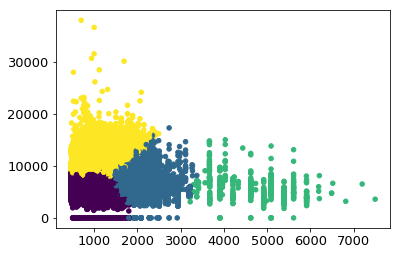

In [65]:
plt.scatter(df_new['WarrantyCost'], df_new['MMR_factor'],
            c=kmeans.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

In [66]:
centers1 = kmeans.cluster_centers_

In [67]:
centers1

array([[0.15735739, 0.14934393, 0.07324157],
       [0.20182205, 0.1803004 , 0.21020267],
       [0.14809688, 0.1444155 , 0.59965106],
       [0.27911385, 0.22677646, 0.08847369]])

In [68]:
df_new.isnull().sum()

MMR_factor      0
VehBCost        0
WarrantyCost    0
dtype: int64

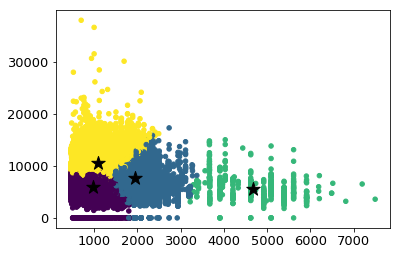

In [71]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)

plt.scatter(df_new['WarrantyCost'], df_new['MMR_factor'], c=kmeans.labels_, 
            s=20)
plt.scatter(centers[:, 2], centers[:, 0], s=200, marker='*', c='k')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

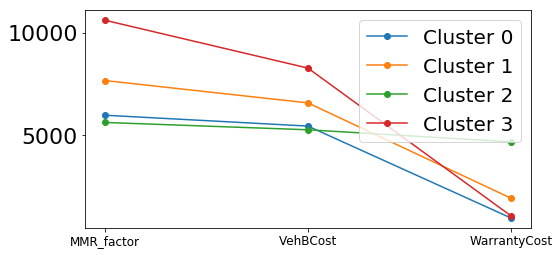

In [72]:
plt.figure(figsize=(8, 4))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(range(0, len(df_new.columns)), df_new.columns, fontsize=12)
plt.legend(fontsize=20)
plt.show()

In [73]:
df_new.head()

,MMR_factor,VehBCost,WarrantyCost
0,8685.25,6100.0,533
1,6459.25,4000.0,1630
2,9635.50,7500.0,693
3,6217.00,4725.0,1633
4,6551.25,5670.0,1623


In [74]:
print('SSE %s' % kmeans.inertia_)
print('Silhouette %s' % silhouette_score(X, kmeans.labels_))

SSE 340.98770600400303
Silhouette 0.3471145901520727


In [75]:
sse_list = list()
max_k = 20
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X)
    
    sse = kmeans.inertia_
    sse_list.append(sse)

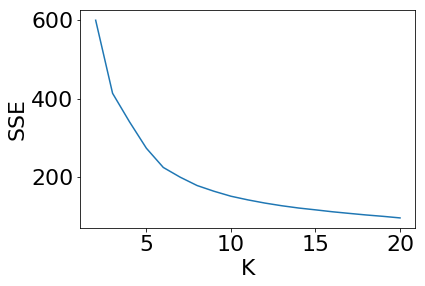

In [76]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()